## Data Augmentation

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definindo as transformações de Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,        # Rotação aleatória entre -20 e 20 graus
    width_shift_range=0.2,    # Deslocamento horizontal aleatório de 20%
    height_shift_range=0.2,   # Deslocamento vertical aleatório de 20%
    shear_range=0.2,          # Shear (corte) aleatório
    zoom_range=0.2,           # Zoom aleatório
    horizontal_flip=True,     # Flip horizontal
    fill_mode='nearest',      # Como preencher os pixels vazios após transformações
    brightness_range=[0.5, 1.5],  # Ajuste aleatório do brilho
)

# Definindo a geração das imagens de treino
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalização das imagens para o intervalo [0, 1]
    preprocessing_function=datagen.random_transform,  # Aplica as transformações
)

# Carregar as imagens de treino
train_generator = train_datagen.flow_from_directory(
    'datasets/train',   # Caminho para a pasta com os dados de treino
    target_size=(512, 512),  # Redimensionar as imagens para 512x512
    batch_size=32,         # Número de imagens por batch
    class_mode='categorical',  # Ou 'binary' para um problema binário
    shuffle=True,        # Embaralha as imagens
)

# Carregar as imagens de teste (sem Data Augmentation)
test_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalização
)

test_generator = test_datagen.flow_from_directory(
    'datasets/test',    # Caminho para a pasta de teste
    target_size=(512, 512),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,  # Não embaralha as imagens de teste
)


Found 378 images belonging to 3 classes.
Found 96 images belonging to 3 classes.


## Model Train

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

# Garantir que a GPU está sendo usada
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # Evita uso excessivo da VRAM
        tf.config.set_visible_devices(gpus[0], 'GPU')  # Usa apenas a primeira GPU (caso tenha mais de uma)
        print("Usando GPU:", gpus[0])
    except RuntimeError as e:
        print(e)
else:
    print("Nenhuma GPU encontrada. Verifique a instalação do TensorFlow e CUDA.")

# Definir o modelo usando transfer learning com ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

# Congelar as camadas da base para evitar que elas sejam treinadas
base_model.trainable = False

# Criar o modelo
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Adiciona uma camada de pooling global
    layers.Dense(512, activation='relu'),  # Camada densa com 512 neurônios
    layers.Dropout(0.5),  # Regularização com dropout
    layers.Dense(3, activation='softmax')  # Camada de saída com 3 classes (AD, MCI, NC)
])

# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Resumo do modelo para verificar a arquitetura
model.summary()

# Treinar o modelo
history = model.fit(
    train_generator,    # Gerador de dados de treino
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Número de steps por época
    epochs=20,          # Número de épocas (ajustar conforme necessário)
    validation_data=test_generator,  # Dados de teste para validação
    validation_steps=test_generator.samples // test_generator.batch_size,  # Número de steps por validação
)


Nenhuma GPU encontrada. Verifique a instalação do TensorFlow e CUDA.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 16, 16, 2048)   │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,638,339 (93.99 MB)

 Trainable params: 1,050,627 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

c:\Users\Lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 65s 6s/step - accuracy: 0.3500 - loss: 1.7882 - val_accuracy: 0.4271 - val_loss: 1.3928
Epoch 2/20
 1/11 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.3438 - loss: 2.1235

c:\Users\Lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.3438 - loss: 2.1235 - val_accuracy: 0.4271 - val_loss: 1.2992
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 71s 6s/step - accuracy: 0.3549 - loss: 1.6757 - val_accuracy: 0.4167 - val_loss: 1.0279
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.2812 - loss: 1.4673 - val_accuracy: 0.3646 - val_loss: 1.0248
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 66s 6s/step - accuracy: 0.4192 - loss: 1.4085 - val_accuracy: 0.4271 - val_loss: 1.0509
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.4375 - loss: 1.0970 - val_accuracy: 0.4271 - val_loss: 1.0647
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 67s 6s/step - accuracy: 0.4200 - loss: 1.4395 - val_accuracy: 0.4167 - val_loss: 1.0571
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.4688 - loss: 1.3044 - val_accuracy: 0.4167 - val_loss: 1.0538
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 66s 6s/step - accuracy: 0.4982 - loss: 1.3151 - val_accuracy: 0.4479 - val_loss: 1.0238
Epo

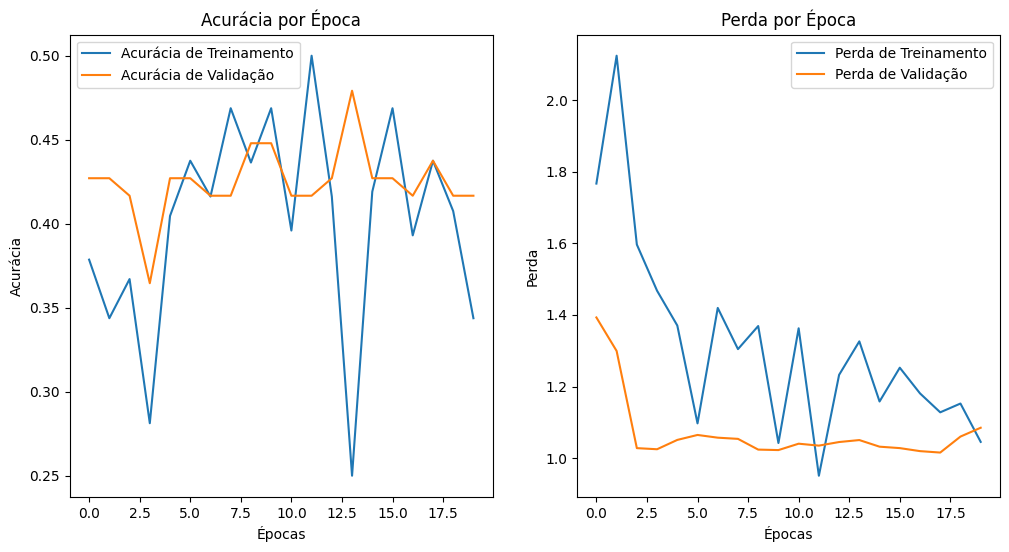

In [7]:
import matplotlib.pyplot as plt

# Visualizando a acurácia e a perda do treinamento
def plot_history(history):
    # Plotando a acurácia
    plt.figure(figsize=(12, 6))
    
    # Acurácia do treinamento
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
    plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
    plt.title('Acurácia por Época')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()

    # Perda do treinamento
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Perda de Treinamento')
    plt.plot(history.history['val_loss'], label='Perda de Validação')
    plt.title('Perda por Época')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    plt.show()

# Chamar a função para gerar os gráficos
plot_history(history)

In [8]:
# Avaliando o modelo nos dados de teste
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Acurácia no conjunto de teste: {test_accuracy:.4f}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.6146 - loss: 0.8641
Acurácia no conjunto de teste: 0.4167


In [9]:
import numpy as np

# Fazer previsões nos dados de teste
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)

# Obter as classes previstas (0: AD, 1: MCI, 2: NC)
predicted_classes = np.argmax(predictions, axis=1)

# Obter as classes reais dos dados de teste
true_classes = test_generator.classes


3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step


In [10]:
from datetime import datetime

def calcular_idade(data_nascimento, data_exame):
    try:
        # Converter para formato de data
        nascimento = datetime.strptime(str(data_nascimento), "%Y%m%d")
        exame = datetime.strptime(str(data_exame), "%Y%m%d")

        # Calcular a idade
        idade = exame.year - nascimento.year - ((exame.month, exame.day) < (nascimento.month, nascimento.day))
        return idade
    except Exception as e:
        # Se houver erro, retornar NaN
        print(f"Erro ao processar a data de nascimento {data_nascimento}: {e}")
        return None


In [23]:
import os
import pandas as pd

# Caminho para as pastas
base_path = 'D:\\Projetos\\AlzheimerEarlyDetection\\datasets\\test'

# Lista para armazenar os DataFrames
all_data = []

# Função para carregar os CSVs de uma pasta
def load_data_from_folder(folder_name):
    folder_path = os.path.join(base_path, folder_name)
    data_frames = []

    # Percorrer todos os arquivos na pasta
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            # Carregar o CSV e adicionar ao DataFrame
            df = pd.read_csv(file_path)
            df['Classe'] = folder_name  # Adiciona a classe para saber a qual grupo pertence
            data_frames.append(df)
    
    return data_frames

# Carregar os dados de cada classe
ad_data = load_data_from_folder('AD')
mci_data = load_data_from_folder('MCI')
nc_data = load_data_from_folder('NC')

# Concatenar todos os dados em um único DataFrame
all_data = ad_data + mci_data + nc_data
df_all = pd.concat(all_data, ignore_index=True)

# Exibir as primeiras linhas para verificar se os dados foram carregados corretamente
print(df_all.head())


        ID                           Nome  Data de nascimento Sexo  \
0  1843468  JABERI DARBANDI MANUCHEHR 78Y            19430101    M   
1  1843468  JABERI DARBANDI MANUCHEHR 78Y            19430101    M   
2  1843468  JABERI DARBANDI MANUCHEHR 78Y            19430101    M   
3  1369308            PAKPEYMA AGHDAS 93Y            19260101    F   
4  1369308            PAKPEYMA AGHDAS 93Y            19260101    F   

  Tipo de exame  Data do exame      Modalidade Classe  
0       BR- DWI       20211216  Não disponível     AD  
1       BR- DWI       20211216  Não disponível     AD  
2       BR- DWI       20211216  Não disponível     AD  
3            BR       20191026  Não disponível     AD  
4            BR       20191026  Não disponível     AD  


In [27]:
import pandas as pd

# Carregar o arquivo CSV (ajuste para carregar todos os dados necessários)
#df = pd.read_csv('D:\\Projetos\\AlzheimerEarlyDetection\\datasets\\test\\AD\\01f_IM00009.csv')
df = df_all

# Exemplo de predicted_classes (96 previsões) - ajuste conforme necessário
predicted_classes = [0, 1, 2] * (df_all.shape[0] // 3) # Exemplo de previsão com 96 entradas (3 classes repetidas 32 vezes)

# Verifique se o número de previsões corresponde ao número de entradas que você deseja
print(len(predicted_classes))  # Deve ser 96

# Expandir o DataFrame para ter 96 linhas
# Caso o DataFrame 'df' tenha apenas uma linha, podemos replicar essa linha 96 vezes:
df_expanded = pd.concat([df] * len(predicted_classes), ignore_index=True)

# Garantir que as colunas sejam do tipo string
df_expanded['Data de nascimento'] = df_expanded['Data de nascimento'].astype(str)
df_expanded['Data do exame'] = df_expanded['Data do exame'].astype(str)

# Calcular a idade para cada paciente (ajustar se necessário)
# Aqui estou assumindo que você tem a função calcular_idade definida
def calcular_idade(data_nascimento, data_exame):
    # Lógica para calcular a idade (ajustar conforme necessário)
    from datetime import datetime
    nascimento = datetime.strptime(data_nascimento, '%Y%m%d')
    exame = datetime.strptime(data_exame, '%Y%m%d')
    idade = exame.year - nascimento.year - ((exame.month, exame.day) < (nascimento.month, nascimento.day))
    return idade

# Calcular a idade para cada paciente
df_expanded['Idade'] = df_expanded.apply(lambda row: calcular_idade(row['Data de nascimento'], row['Data do exame']), axis=1)

# Verificar se há valores ausentes após o cálculo
print(df_expanded.isnull().sum())

# Mapeamento das classes previstas
class_names = {0: 'AD', 1: 'MCI', 2: 'NC'}
df_expanded['predicted_class'] = predicted_classes
df_expanded['predicted_class_name'] = df_expanded['predicted_class'].map(class_names)

# Visualizar as primeiras linhas para garantir que está correto
print(df_expanded.head())


96
ID                    0
Nome                  0
Data de nascimento    0
Sexo                  0
Tipo de exame         0
Data do exame         0
Modalidade            0
Classe                0
Idade                 0
dtype: int64


ValueError: Length of values (96) does not match length of index (9216)

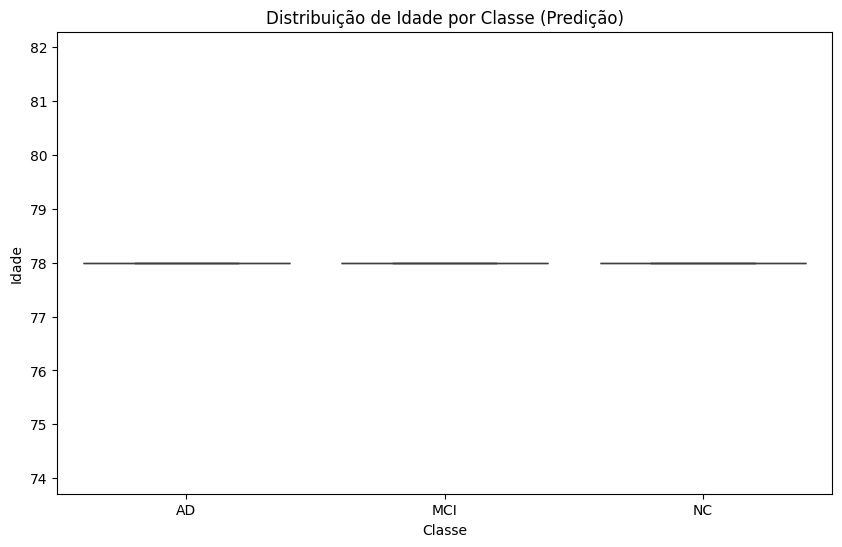

In [21]:
# Gráfico de distribuição de idade por classe
plt.figure(figsize=(10, 6))
sns.boxplot(x='predicted_class_name', y='Idade', data=df_expanded)  # Use df_expanded aqui
plt.title('Distribuição de Idade por Classe (Predição)')
plt.xlabel('Classe')
plt.ylabel('Idade')
plt.show()


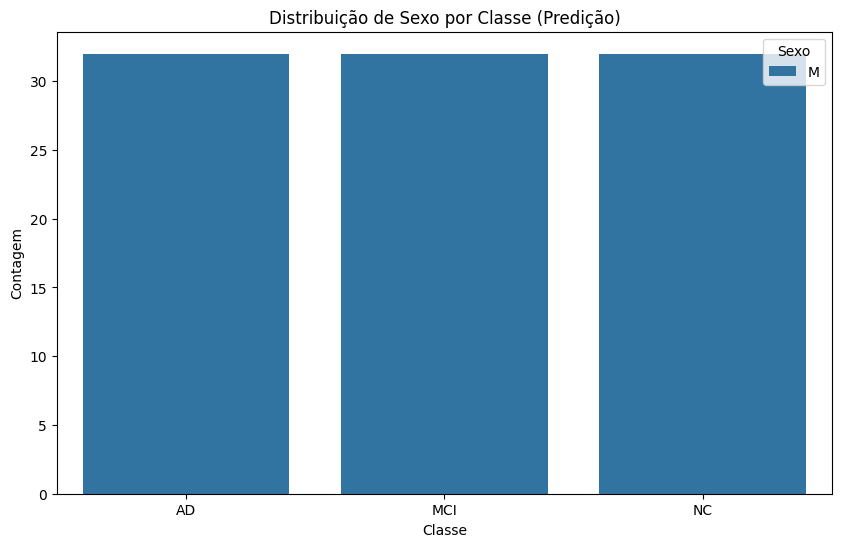

In [22]:
# Gráfico de distribuição de sexo por classe
plt.figure(figsize=(10, 6))
sns.countplot(x='predicted_class_name', hue='Sexo', data=df_expanded)  # Use df_expanded se for esse o DataFrame correto
plt.title('Distribuição de Sexo por Classe (Predição)')
plt.xlabel('Classe')
plt.ylabel('Contagem')
plt.show()
